# OCR lora finetuning and merging using Unsloth

## Import required libraries

In [1]:
from unsloth import FastVisionModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig,Qwen2VLProcessor
from peft import LoraConfig
from qwen_vl_utils import process_vision_info
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import glob
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
import random

## Dataset Preparation

In [3]:
from datasets import load_dataset

dataset = load_dataset("lbourdois/OCR-liboaccn-OPUS-MIT-5M-clean", 'en', split="train")
# To select the first 2000 examples
train_dataset = dataset.select(range(2000))

# To select the next 200 examples for evaluation
eval_dataset = dataset.select(range(2000, 2200))

# Convert dataset to OAI messages       
def format_data(sample):
    return {"messages": [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": sample["question"],
                        },{
                            "type": "image",
                            "image": sample["image"],
                        }
                    ],
                },
                {
                    "role": "assistant",
                    "content": [{"type": "text", "text": sample["answer"]}],
                },
            ],
        }

system_message = "You are an expert french ocr system."
# Convert dataset to OAI messages
# need to use list comprehension to keep Pil.Image type, .mape convert image to bytes
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/50 [00:00<?, ?it/s]

## Setup OCR main evaluation function and helpers

In [5]:
import os
import torch
from tqdm import tqdm
import pandas as pd
from jiwer import wer, cer
from qwen_vl_utils import process_vision_info

def evaluate_ocr_model(model, processor, dataset, output_dir="ocr_evaluation_results"):
    """
    Evaluate a Qwen VL model on an OCR dataset with specific structure.
    
    Args:
        model: The loaded Qwen VL model
        processor: The Qwen processor/tokenizer
        dataset: List of items with 'messages' field containing conversation exchanges
        output_dir: Directory to save results
    
    Returns:
        tuple: (average WER, average CER)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize results storage
    results = []
    
    # Process each sample in the dataset
    for i, sample in enumerate(tqdm(dataset, desc="Evaluating OCR performance")):
        try:
            # Extract the messages from the sample
            messages = sample['messages']
            
            # Extract system message (if present)
            system_message = next((msg for msg in messages if msg['role'] == 'system'), None)
            
            # Extract user message with the image and question
            user_message = next((msg for msg in messages if msg['role'] == 'user'), None)
            if not user_message:
                print(f"Skipping sample {i}: No user message found")
                continue
                
            # Extract assistant message with ground truth
            assistant_message = next((msg for msg in messages if msg['role'] == 'assistant'), None)
            if not assistant_message:
                print(f"Skipping sample {i}: No assistant message (ground truth) found")
                continue
            
            # Extract ground truth text
            ground_truth = None
            for content_item in assistant_message['content']:
                if content_item['type'] == 'text':
                    ground_truth = content_item['text']
                    break
                    
            if not ground_truth:
                print(f"Skipping sample {i}: No text found in assistant message")
                continue
            
            # Extract image and question from user message
            image = None
            question = None
            
            for content_item in user_message['content']:
                if content_item['type'] == 'image':
                    image = content_item['image']
                elif content_item['type'] == 'text':
                    question = content_item['text']
            
            if not image:
                print(f"Skipping sample {i}: No image found in user message")
                continue
                
            if not question:
                print(f"Skipping sample {i}: No question found in user message")
                continue
            
            # Construct messages for the model input (excluding assistant message)
            input_messages = []
            
            # Add system message if it exists
            if system_message:
                input_messages.append(system_message)
            
            # Add user message
            input_messages.append(user_message)
            
            # Preparation for inference using Qwen's specific processing
            text = processor.apply_chat_template(
                input_messages, tokenize=False, add_generation_prompt=True
            )
            
            # Process vision info (images/videos) from messages
            image_inputs, video_inputs = process_vision_info(input_messages)
            
            # Create model inputs
            inputs = processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt"
            )
            inputs = inputs.to(model.device)
            
            # Generate response
            with torch.no_grad():
                generated_ids = model.generate(
                    **inputs, 
                    max_new_tokens=1024, 
                    # top_p=0.9, 
                    # temperature=1.0
                    temperature=1.5, 
                    min_p=0.1,
                    use_cache=True
                )
            
            # Extract only the generated part (not the input)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            
            # Decode the generated text
            generated_response = processor.batch_decode(
                generated_ids_trimmed, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=False
            )[0]
            
            # Calculate metrics
            word_error = wer(ground_truth, generated_response)
            char_error = cer(ground_truth, generated_response)
            
            # Save individual result
            output_file = os.path.join(output_dir, f"sample_{i}.txt")
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(f"Sample {i}\n")
                f.write(f"Question: {question}\n\n")
                f.write(f"Model output:\n{generated_response.strip()}\n\n")
                f.write(f"Ground truth:\n{ground_truth}\n\n")
                f.write(f"WER: {word_error:.4f}, CER: {char_error:.4f}")
            
            # Store results for summary
            results.append({
                'sample_id': i,
                'wer': word_error,
                'cer': char_error,
                'model_output': generated_response.strip(),
                'ground_truth': ground_truth,
                'question': question
            })
            
        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            import traceback
            traceback.print_exc()
            
    # Create summary report
    if results:
        df = pd.DataFrame(results)
        
        # Calculate overall averages
        avg_wer = df['wer'].mean()
        avg_cer = df['cer'].mean()
        
        # Save average metrics
        with open(os.path.join(output_dir, "avg_metrics.txt"), 'w') as f:
            f.write(f"Average WER: {avg_wer:.4f}\n")
            f.write(f"Average CER: {avg_cer:.4f}\n")
        
        # Save detailed results
        df.to_csv(os.path.join(output_dir, "detailed_results.csv"), index=False)
        
        print("\nResults Summary:")
        print(f"Average WER: {avg_wer:.4f}")
        print(f"Average CER: {avg_cer:.4f}")
        print(f"\nDetailed results saved to {output_dir}/")
        
        return avg_wer, avg_cer
    else:
        print("No results to summarize.")
        return None, None


# At the beginning of your notebook, define a variable to collect results
model_comparison_results = {}

# Create a simple function to add results to the comparison
def add_to_comparison(model_name, wer, cer):
    """Add model results to the comparison tracker"""
    model_comparison_results[model_name] = {
        "wer": wer,
        "cer": cer
    }
    #return model_comparison_results

# Create a function to print the comparison report whenever needed
def print_model_comparison(save_csv=True, save_plot=True):
    """Print a comparison of all models evaluated so far"""
    if not model_comparison_results:
        print("No model results available for comparison")
        return
        
    print("\n==== MODEL COMPARISON REPORT ====")
    
    # Create a comparison dataframe
    comparison_df = pd.DataFrame({
        "Model": list(model_comparison_results.keys()),
        "WER": [results["wer"] for results in model_comparison_results.values()],
        "CER": [results["cer"] for results in model_comparison_results.values()]
    })
    
    # Sort by WER (best performance first)
    comparison_df = comparison_df.sort_values("WER")
    
    # Display the comparison table
    print("\nComparison Table (sorted by WER):")
    print(comparison_df.to_string(index=False))
    
    # Save the comparison table
    if save_csv:
        comparison_file = "model_comparison_results.csv"
        comparison_df.to_csv(comparison_file, index=False)
        print(f"\nComparison table saved to {comparison_file}")
    
    # Generate a bar chart visualization
    if save_plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        
        # Plot WER
        plt.subplot(1, 2, 1)
        plt.bar(comparison_df["Model"], comparison_df["WER"], color='skyblue')
        plt.title('Word Error Rate Comparison')
        plt.ylabel('WER (lower is better)')
        plt.ylim(bottom=0)
        plt.xticks(rotation=45, ha='right')
        
        # Plot CER
        plt.subplot(1, 2, 2)
        plt.bar(comparison_df["Model"], comparison_df["CER"], color='lightgreen')
        plt.title('Character Error Rate Comparison')
        plt.ylabel('CER (lower is better)')
        plt.ylim(bottom=0)
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('ocr_model_comparison.png')
        plt.show()
        
        print(f"\nVisualization saved to ocr_model_comparison.png")
    
    return comparison_df

## Finetuning Setup and Run

In [6]:
# Load Base Model

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "unsloth/Qwen2-VL-7B-Instruct",
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
)

==((====))==  Unsloth 2025.5.6: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.254 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
# benchmark base model performance
model_name = "Unsloth Base model" 
FastVisionModel.for_inference(model)
avg_wer, avg_cer = evaluate_ocr_model(model, tokenizer, eval_dataset, output_dir="unsloth_base_model_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:18<00:00,  1.01it/s]


Results Summary:
Average WER: 0.1707
Average CER: 0.0899

Detailed results saved to unsloth_base_model_results/


## Lora Finetuning

In [8]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!

    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Making `model.base_model.model.model` require gradients


In [14]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
FastVisionModel.for_training(model) # Enable for training!
model.config.use_cache = False


trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = train_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 8,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
        max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
        warmup_ratio=0.03,
        num_train_epochs = 2, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 5,
        save_strategy="epoch",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "unsloth-qwen2-7vl-french-ocr-checkpoints",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [15]:
# run training
trainer_stats = trainer.train()

model.save_pretrained("unsloth-qwen2-7vl-french-ocr-adapter", tokenizer)
tokenizer.save_pretrained("unsloth-qwen2-7vl-french-ocr-adapter")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,000 | Num Epochs = 2 | Total steps = 124
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)


Step,Training Loss
5,1.925900
10,0.400700
15,0.097200
20,0.071300
25,0.076500
30,0.071400
35,0.071600
40,0.069200
45,0.065900
50,0.068000


[]

## Measure Adapter Performance

In [16]:
# benchmark lora model performance
model_name = "Unsloth lora adapter model" 
FastVisionModel.for_inference(model)
avg_wer, avg_cer = evaluate_ocr_model(model, tokenizer, eval_dataset, output_dir="unsloth_lora_model_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:27<00:00,  1.64s/it]


Results Summary:
Average WER: 0.0059
Average CER: 0.0010

Detailed results saved to unsloth_lora_model_results/


## Merge Model

In [17]:
# merge default 16 bits
model.save_pretrained_merged(save_directory="qwen2-ocr-merged-finetune-merge-16bit", tokenizer=tokenizer)

Found HuggingFace hub cache directory: /home/mlengineer/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|                                                                                               | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  25%|█████████████████████▊                                                                 | 1/4 [00:27<01:23, 27.67s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|███████████████████████████████████████████▌                                           | 2/4 [01:00<01:01, 30.85s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  75%|█████████████████████████████████████████████████████████████████▎                     | 3/4 [01:29<00:29, 29.92s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:37<00:00, 24.40s/it]


In [18]:
# merge 4 bits
model.save_pretrained_merged(save_directory="qwen2-ocr-merged-finetune-merge-4bit", tokenizer=tokenizer, save_method="merged_4bit_forced")

Unsloth: Merging LoRA weights into 4bit model...


/conda/envs/unsloth_latest/lib/python3.11/site-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Unsloth: Merging finished.
Unsloth: Found skipped modules: ['visual.blocks.0.attn.qkv', 'visual.blocks.0.attn.proj', 'visual.blocks.0.mlp.fc1', 'visual.blocks.0.mlp.fc2', 'visual.blocks.1.attn.qkv', 'visual.blocks.1.attn.proj', 'visual.blocks.1.mlp.fc1', 'visual.blocks.1.mlp.fc2', 'visual.blocks.2.attn.qkv', 'visual.blocks.2.attn.proj', 'visual.blocks.2.mlp.fc1', 'visual.blocks.2.mlp.fc2', 'visual.blocks.3.attn.qkv', 'visual.blocks.3.attn.proj', 'visual.blocks.3.mlp.fc1', 'visual.blocks.3.mlp.fc2', 'visual.blocks.4.attn.qkv', 'visual.blocks.4.attn.proj', 'visual.blocks.4.mlp.fc1', 'visual.blocks.4.mlp.fc2', 'visual.blocks.5.attn.qkv', 'visual.blocks.5.attn.proj', 'visual.blocks.5.mlp.fc1', 'visual.blocks.5.mlp.fc2', 'visual.blocks.6.attn.qkv', 'visual.blocks.6.attn.proj', 'visual.blocks.6.mlp.fc1', 'visual.blocks.6.mlp.fc2', 'visual.blocks.7.attn.qkv', 'visual.blocks.7.attn.proj', 'visual.blocks.7.mlp.fc1', 'visual.blocks.7.mlp.fc2', 'visual.blocks.8.attn.qkv', 'visual.blocks.8.attn.pr

## Benchmark merged model performance

### 16 bits merged model

In [6]:
# load 16bits-merged model in 4 bits
model, tokenizer = FastVisionModel.from_pretrained("./qwen2-ocr-merged-finetune-merge-16bit",load_in_4bit=True, load_in_8bit=False)

==((====))==  Unsloth 2025.5.6: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.254 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
# benchmark 4bit loaded, 16bits merged model performance
model_name = "Unsloth 16bits-merged model load-4bits" 
model.config.use_cache = True

avg_wer, avg_cer = evaluate_ocr_model(model, tokenizer, eval_dataset, output_dir="unsloth_16bits_merged_model_load_4bits_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [18:09<00:00,  5.45s/it]


Results Summary:
Average WER: 3.5484
Average CER: 3.6879

Detailed results saved to unsloth_16bits_merged_model_load_4bits_results/


In [8]:
# load model in 8 bits
model, tokenizer = FastVisionModel.from_pretrained("./qwen2-ocr-merged-finetune-merge-16bit",load_in_4bit=False, load_in_8bit=True)

==((====))==  Unsloth 2025.5.6: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.254 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
# benchmark 4bit loaded, 16bits merged model performance
model_name = "Unsloth 16bits-merged model load-8bits" 
avg_wer, avg_cer = evaluate_ocr_model(model, tokenizer, eval_dataset, output_dir="unsloth_16bits_merged_model_load_8bits_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


Results Summary:
Average WER: 0.0050
Average CER: 0.0009

Detailed results saved to unsloth_16bits_merged_model_load_8bits_results/


### 4 bits merged model

In [10]:
# load 4bits-merged model in 4 bits
model, tokenizer = FastVisionModel.from_pretrained("./qwen2-ocr-merged-finetune-merge-4bit",load_in_4bit=True, load_in_8bit=False)

==((====))==  Unsloth 2025.5.6: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.254 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# benchmark 4bit loaded, 4bits merged model performance
model_name = "Unsloth 4bits-merged model load-4bits" 

avg_wer, avg_cer = evaluate_ocr_model(model, tokenizer, eval_dataset, output_dir="unsloth_4bits_merged_model_load_4bits_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:16<00:00,  1.02it/s]


Results Summary:
Average WER: 0.1499
Average CER: 0.0745

Detailed results saved to unsloth_4bits_merged_model_load_4bits_results/


In [12]:
# load model in 8 bits
model, tokenizer = FastVisionModel.from_pretrained("./qwen2-ocr-merged-finetune-merge-4bit",load_in_4bit=False, load_in_8bit=True)

==((====))==  Unsloth 2025.5.6: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.254 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
# benchmark 8bit loaded, 4bits merged model performance
model_name = "Unsloth 4bits-merged model load-8bits" 

avg_wer, avg_cer = evaluate_ocr_model(model, tokenizer, eval_dataset, output_dir="unsloth_4bits_merged_model_load_8bits_results")
add_to_comparison(model_name, avg_wer, avg_cer)

Evaluating OCR performance: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:16<00:00,  1.02it/s]


Results Summary:
Average WER: 0.1499
Average CER: 0.0745

Detailed results saved to unsloth_4bits_merged_model_load_8bits_results/


# Model comparison report


==== MODEL COMPARISON REPORT ====

Comparison Table (sorted by WER):
                                 Model      WER      CER
Unsloth 16bits-merged model load-8bits 0.005011 0.000896
            Unsloth lora adapter model 0.005900 0.001000
 Unsloth 4bits-merged model load-8bits 0.149930 0.074493
 Unsloth 4bits-merged model load-4bits 0.149930 0.074493
                    Unsloth Base model 0.170700 0.089900
Unsloth 16bits-merged model load-4bits 3.548406 3.687869

Comparison table saved to model_comparison_results.csv


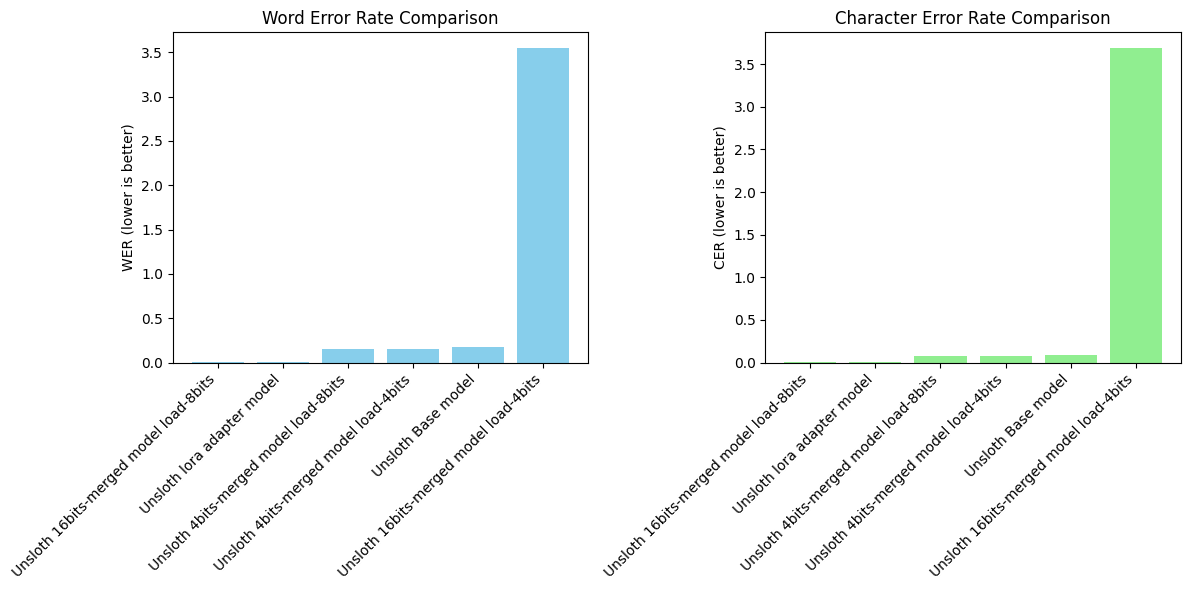


Visualization saved to ocr_model_comparison.png


,Model,WER,CER
1,Unsloth 16bits-merged model load-8bits,0.005011,0.000896
5,Unsloth lora adapter model,0.005900,0.001000
3,Unsloth 4bits-merged model load-8bits,0.149930,0.074493
2,Unsloth 4bits-merged model load-4bits,0.149930,0.074493
4,Unsloth Base model,0.170700,0.089900
0,Unsloth 16bits-merged model load-4bits,3.548406,3.687869


In [15]:
import matplotlib
#print model comparison
print_model_comparison()

<!-- # Load adapter model and measure adapter performance

# # Load model and tokenizer
# model = AutoModelForVision2Seq.from_pretrained(
#     "./merged_model_french_ocr_qwen7-vl",
#     device_map="auto",
#     # attn_implementation="flash_attention_2", # not supported for training
#     torch_dtype=torch.bfloat16,
#     #quantization_config=bnb_config
# )

model, tokenizer = FastVisionModel.from_pretrained("./merged_model_french_ocr_qwen7-vl",load_in_8bit=True, load_in_4bit=False)
FastVisionModel.for_inference(model) -->